# LSTM model for forecasting temperature

Import necessary libs

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import math
from datetime import datetime as dt
from pandas import date_range
from datetime import timedelta

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Activation, Dropout,RepeatVector,TimeDistributed
from tensorflow.keras.optimizers import Adam,SGD,Nadam

### Read file

In [15]:
temperature_data = pd.read_csv("temperature_data/VIC/vic_temperature_data.csv")

In [16]:
temperature_data

,Product code_x,Station Number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality_x,Product code_y,Minimum temperature (Degree C),Days of accumulation of minimum temperature,Quality_y,stationname,localgovernmentarea,latitude,longtitude,Date Time
0,IDCJAC0010,76031.0,2000.0,1,1.0,24.9,1.0,Y,IDCJAC0011,10.7,1.0,Y,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2000-01-01
1,IDCJAC0010,76031.0,2000.0,1,2.0,30.9,1.0,Y,IDCJAC0011,12.5,1.0,Y,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2000-01-02
2,IDCJAC0010,76031.0,2000.0,1,3.0,34.8,1.0,Y,IDCJAC0011,17.7,1.0,Y,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2000-01-03
3,IDCJAC0010,76031.0,2000.0,1,4.0,24.3,1.0,Y,IDCJAC0011,13.0,1.0,Y,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2000-01-04
4,IDCJAC0010,76031.0,2000.0,1,5.0,25.6,1.0,Y,IDCJAC0011,9.7,1.0,Y,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2000-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586471,IDCJAC0010,90186.0,2020.0,8,2.0,15.0,1.0,N,IDCJAC0011,5.8,1.0,N,WARRNAMBOOL AIRPORT NDB,Warrnambool,-38.2867,142.4522,2020-08-02
586472,IDCJAC0010,90186.0,2020.0,8,3.0,12.9,1.0,N,IDCJAC0011,5.9,1.0,N,WARRNAMBOOL AIRPORT NDB,Warrnambool,-38.2867,142.4522,2020-08-03
586473,IDCJAC0010,90186.0,2020.0,8,4.0,10.6,1.0,N,IDCJAC0011,2.5,1.0,N,WARRNAMBOOL AIRPORT NDB,Warrnambool,-38.2867,142.4522,2020-08-04
586474,IDCJAC0010,90186.0,2020.0,8,5.0,11.0,1.0,N,IDCJAC0011,5.6,1.0,N,WARRNAMBOOL AIRPORT NDB,Warrnambool,-38.2867,142.4522,2020-08-05


### Find out the number of LGAs

In [17]:
temperature_data['localgovernmentarea'].unique()

array(['Mildura Shire', 'Swan Hill', 'Horsham',
       'Naracoorte and Lucindale', 'Northern Grampians', 'Campaspe',
       'Central Goldfields', 'Greater Shepparton', 'Greater Bendigo',
       'Moira', 'Corowa Shire', 'Murrindindi', 'Alpine', 'Wangaratta',
       'Greater Hume Shire', 'Benalla', 'Mansfield', 'Bega Valley',
       'East Gippsland', 'Bombala', 'Wellington', 'Latrobe',
       'Moonee Valley', 'Banyule', nan, 'Knox', 'Bass Coast', 'Brimbank',
       'Mornington Peninsula', 'Casey', 'Yarra Ranges', 'Wyndham',
       'Greater Geelong', 'Mount Alexander', 'Whittlesea',
       'Ballarat North', 'Ararat', 'Colac-Otway', 'Glenelg',
       'Southern Grampians', 'Moyne', 'Warrnambool', 'Surf Coast',
       'Grant'], dtype=object)

### Get the data from one LGA

In [18]:
selected_lga="Mildura Shire"
selected_lga_data = temperature_data[temperature_data['localgovernmentarea']=="Mildura Shire"]

### Get the data from one weather station

In [19]:
selected_lga_data['stationname'].unique()

array(['MILDURA AIRPORT ', 'OUYEN (POST OFFICE) ', 'WALPEUP RESEARCH ',
       'HOPETOUN AIRPORT '], dtype=object)

In [20]:
selected_station="MILDURA AIRPORT "
selected_station_data=selected_lga_data[selected_lga_data['stationname']=="MILDURA AIRPORT "]

In [21]:
station_latitude = selected_station_data["latitude"][0]
station_longtitude = selected_station_data["longtitude"][0]
selected_station_data

,Product code_x,Station Number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality_x,Product code_y,Minimum temperature (Degree C),Days of accumulation of minimum temperature,Quality_y,stationname,localgovernmentarea,latitude,longtitude,Date Time
0,IDCJAC0010,76031.0,2000.0,1,1.0,24.9,1.0,Y,IDCJAC0011,10.7,1.0,Y,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2000-01-01
1,IDCJAC0010,76031.0,2000.0,1,2.0,30.9,1.0,Y,IDCJAC0011,12.5,1.0,Y,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2000-01-02
2,IDCJAC0010,76031.0,2000.0,1,3.0,34.8,1.0,Y,IDCJAC0011,17.7,1.0,Y,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2000-01-03
3,IDCJAC0010,76031.0,2000.0,1,4.0,24.3,1.0,Y,IDCJAC0011,13.0,1.0,Y,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2000-01-04
4,IDCJAC0010,76031.0,2000.0,1,5.0,25.6,1.0,Y,IDCJAC0011,9.7,1.0,Y,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2000-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7519,IDCJAC0010,76031.0,2020.0,8,2.0,21.1,1.0,N,IDCJAC0011,5.8,1.0,N,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2020-08-02
7520,IDCJAC0010,76031.0,2020.0,8,3.0,19.5,1.0,N,IDCJAC0011,5.5,1.0,N,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2020-08-03
7521,IDCJAC0010,76031.0,2020.0,8,4.0,14.0,1.0,N,IDCJAC0011,4.0,1.0,N,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2020-08-04
7522,IDCJAC0010,76031.0,2020.0,8,5.0,14.1,1.0,N,IDCJAC0011,-1.1,1.0,N,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867,2020-08-05


### Extract the minimum temperature

In [22]:
selected_station_mintemp=selected_station_data[["Date Time","Minimum temperature (Degree C)"]]

In [23]:
selected_station_mintemp['Date Time']=pd.to_datetime(selected_station_mintemp['Date Time'])
selected_station_mintemp = selected_station_mintemp.set_index(selected_station_mintemp.columns[0])

c:\users\ngoct\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='Date Time'>

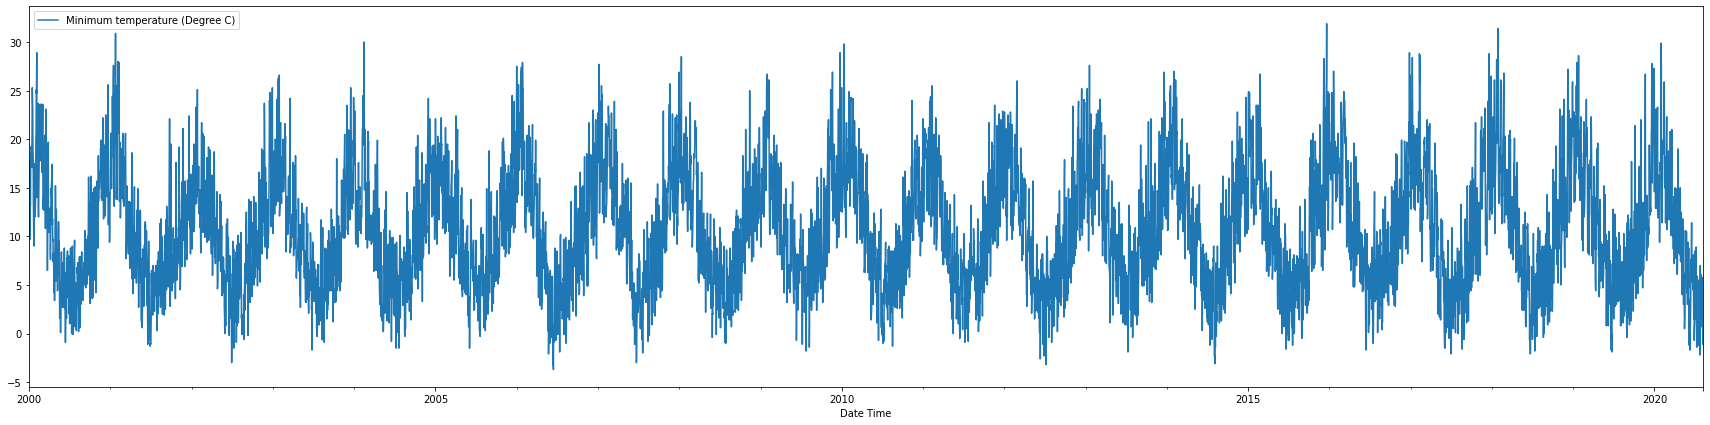

In [24]:
selected_station_mintemp.plot(figsize=(30,7))

### Extract the maximum data

c:\users\ngoct\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:xlabel='Date Time'>

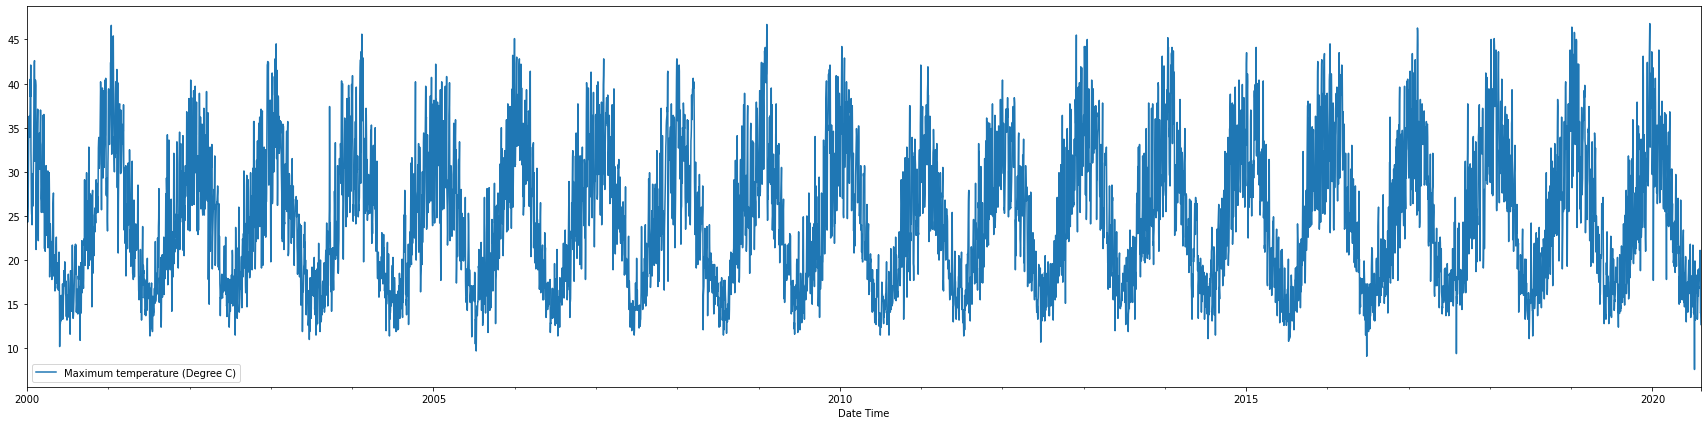

In [25]:
selected_station_maxtemp=selected_station_data[["Date Time","Maximum temperature (Degree C)"]]
selected_station_maxtemp['Date Time']=pd.to_datetime(selected_station_maxtemp['Date Time'])
selected_station_maxtemp = selected_station_maxtemp.set_index(selected_station_maxtemp.columns[0])
selected_station_maxtemp.plot(figsize=(30,7))

### Train test split

In [26]:
def train_test_split(data_set,name,ratio):
    print(name+' total samples: ',len(data_set))
    split_row = int(len(data_set)*ratio)
    print('Training samples: ',split_row)
    print('Testing samples: ',len(data_set)-split_row)
    train_set = data_set.iloc[:split_row]
    test_set = data_set.iloc[split_row:]
    return train_set, test_set, split_row 
    

### Data Transformation

We need to scale the the data so it will reduce the computional cost of the training step

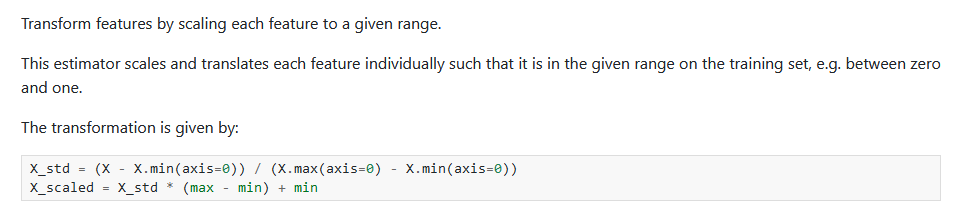
We will use Minmax Scaler from sklearn library

In [27]:
def data_transformation(train_data,testing_data):
    my_scaler=MinMaxScaler(feature_range=(-1,1))
    train_data_scaled = my_scaler.fit_transform(train_data)
    test_data_scaled = my_scaler.fit_transform(testing_data)
    scaled_train_data_df = pd.DataFrame(train_data_scaled, index = train_data.index, columns=[train_data.columns[0]])
    test_data_scaled_df = pd.DataFrame(test_data_scaled, index = testing_data.index, columns=[testing_data.columns[0]])
    
    return scaled_train_data_df,test_data_scaled_df,my_scaler

Create lagged values for the time series data

In [28]:
def add_lagged_value(df,lag=1):
    data_cp = df.copy()
    for i in range (1,lag):
        data_cp['lag' + str(i)] = df.shift(i)
    return data_cp

In [29]:
def extract_x_y(data):
    return data.columns[0].values

In [30]:
#This function add time step our training model
#So we will use the last number of time step day to predict temperature of next day
def add_time_step(x,y,time_steps):
    x_p,y_p=[],[]
    for i in range (len(x) - time_steps):
        x_p.append(x.iloc[i:(i+time_steps)].values)    
        y_p.append(y[i + time_steps])
    x_tr,y_tr=np.array(x_p),np.array(y_p)
    x_tr = np.reshape(x_tr, (x_tr.shape[0], x_tr.shape[1], 1))
    y_tr = np.reshape(y_tr, (y_tr.shape[0], 1))
    return x_tr,y_tr

In [31]:
train_data,test_data,split_r= train_test_split(selected_station_mintemp,"mildura",0.8)

mildura total samples:  7524
Training samples:  6019
Testing samples:  1505


## Define LSTM model

LSTM model includes 3 stacked LSTM layer with the output layer is dense layer. We will use drop out (20%) to prevent the gradient vanishing problem and Adam for gradient optimization

In [32]:
def lstm(units, x_train,y_train,EPOCHS,size_batch):
    model = Sequential()
    model.add(Bidirectional(LSTM(units,return_sequences=False, recurrent_dropout=0.2,input_shape=(x_train.shape[1],1))))
    model.add(Dropout(0.2))
    #model.add(LSTM(units,return_sequences=True))
    #model.add(Dropout(0.2))
    #model.add(LSTM(units,return_sequences=False))
    #model.add(Dropout(0.2)) 
    model.add(Dense(1))
    model.compile(optimizer=Nadam(lr=0.001),loss='mean_squared_error',metrics=['mae'])

    hist = model.fit(x_train,y_train,batch_size=size_batch,epochs=EPOCHS,shuffle=False,verbose=1)
    return model,hist

### Validation test

In [33]:
def validation_test(model,x_test,y_test,scaler,split_row,lag):
    y_predict= model.predict(x_test)
    score = r2_score(y_test,y_predict)
    print('Test R-squared is: ' + str(score))
    # we need to inverse value (0-1) to the normal temperature C value
    y_predict= scaler.inverse_transform(y_predict)
    result=x_test.copy()
    result['true_y']=y_test
    result['forecast']=y_predict
    return result

## Temperature Predicting Model

In [40]:
def min_temp_lstm(station_name,data_from_station,lag,split_ratio):
    train_data,test_data,split_row=train_test_split(data_from_station,station_name,split_ratio)
    train_data_scaled,test_data_scaled,my_scaler = data_transformation(train_data,test_data)
    #print(train_data_scaled)
    x_train,y_train=add_time_step(train_data_scaled,train_data_scaled["Minimum temperature (Degree C)"],lag)
    model,hist = lstm(30,x_train,y_train,40,120)
    return model,hist,test_data_scaled,my_scaler

def max_temp_lstm(station_name,data_from_station,lag,split_ratio):
    train_data,test_data,split_row=train_test_split(data_from_station,station_name,split_ratio)
    train_data_scaled,test_data_scaled,my_scaler = data_transformation(train_data,test_data)
    #print(train_data_scaled)
    x_train,y_train=add_time_step(train_data_scaled,train_data_scaled["Maximum temperature (Degree C)"],lag)
    model,hist = lstm(30,x_train,y_train,40,120)
    return model,hist,test_data_scaled,my_scaler

### Train forecasting minimum temperature model

In [41]:
min_model,min_hist,min_test,min_scaler = min_temp_lstm("Mildura Shire",selected_station_mintemp,210,0.9)

Mildura Shire total samples:  7524
Training samples:  6771
Testing samples:  753
Train on 6561 samples
Epoch 1/40
6561/6561 [==============================] - 57s 9ms/sample - loss: 0.0768 - mae: 0.2211
Epoch 2/40
6561/6561 [==============================] - 51s 8ms/sample - loss: 0.0512 - mae: 0.1822
Epoch 3/40
6561/6561 [==============================] - 51s 8ms/sample - loss: 0.0485 - mae: 0.1772
Epoch 4/40
6561/6561 [==============================] - 54s 8ms/sample - loss: 0.0472 - mae: 0.1746
Epoch 5/40
6561/6561 [==============================] - 55s 8ms/sample - loss: 0.0457 - mae: 0.1722
Epoch 6/40
6561/6561 [==============================] - 53s 8ms/sample - loss: 0.0444 - mae: 0.1697
Epoch 7/40
6561/6561 [==============================] - 54s 8ms/sample - loss: 0.0439 - mae: 0.1683
Epoch 8/40
6561/6561 [==============================] - 56s 9ms/sample - loss: 0.0434 - mae: 0.1677
Epoch 9/40
6561/6561 [==============================] - 56s 9ms/sample - loss: 0.0421 - mae: 0.16

### Train forecasting maximum temperature model

In [51]:
max_model,max_hist,max_test,max_scaler = max_temp_lstm("Mildura Shire",selected_station_maxtemp,210,0.9)

Mildura Shire total samples:  7524
Training samples:  6771
Testing samples:  753
Train on 6561 samples
Epoch 1/40
6561/6561 [==============================] - 69s 10ms/sample - loss: 0.0860 - mae: 0.2360
Epoch 2/40
6561/6561 [==============================] - 67s 10ms/sample - loss: 0.0587 - mae: 0.1925
Epoch 3/40
6561/6561 [==============================] - 66s 10ms/sample - loss: 0.0553 - mae: 0.1873
Epoch 4/40
6561/6561 [==============================] - 62s 9ms/sample - loss: 0.0535 - mae: 0.1839
Epoch 5/40
6561/6561 [==============================] - 63s 10ms/sample - loss: 0.0521 - mae: 0.1816
Epoch 6/40
6561/6561 [==============================] - 62s 10ms/sample - loss: 0.0509 - mae: 0.1794
Epoch 7/40
6561/6561 [==============================] - 60s 9ms/sample - loss: 0.0496 - mae: 0.1769
Epoch 8/40
6561/6561 [==============================] - 70s 11ms/sample - loss: 0.0488 - mae: 0.1756
Epoch 9/40
6561/6561 [==============================] - 67s 10ms/sample - loss: 0.0477 - ma

## Evaluate the model

### Evaluating minimum temperature model

Text(0, 0.5, 'MAE')

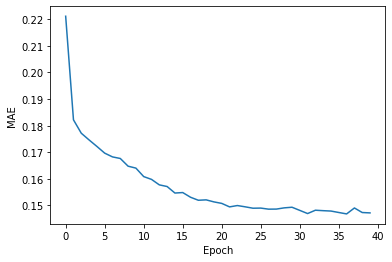

In [42]:
# Plot the mae graph for min temperature model
plt.plot(min_hist.history['mae'])
plt.xlabel('Epoch')
plt.ylabel('MAE')

In [43]:
x_test,y_test=add_time_step(min_test,min_test["Minimum temperature (Degree C)"],210)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [45]:
predicted_temp=min_model.predict(x_test,verbose=1)

543/543 [==============================] - 4s 8ms/sample


In [46]:
predicted_temp=predicted_temp.reshape((predicted_temp.shape[0],1))

In [47]:
# Scale the data back to normal form
predicted_temp=min_scaler.inverse_transform(predicted_temp)
y_test=min_scaler.inverse_transform(y_test)

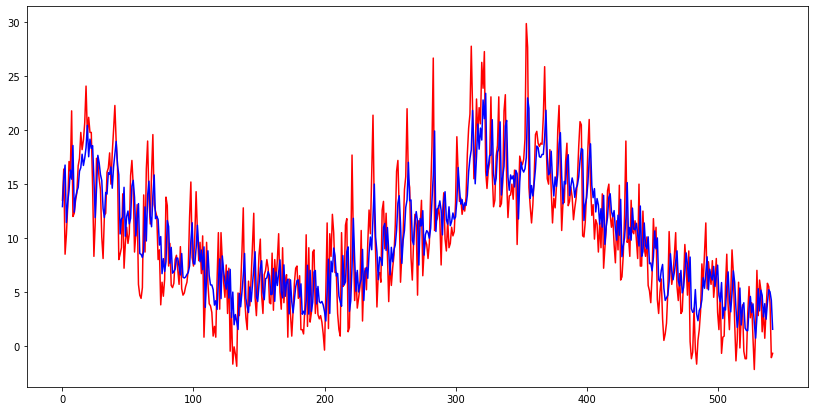

In [48]:
plt.figure(figsize=(14,7))
plt.plot(y_test, color = "red")
plt.plot(predicted_temp,color="blue")

In [49]:
r2_score(y_test,predicted_temp)

0.6814704723423591

### Evaluating minimum temperature model

Text(0, 0.5, 'MAE')

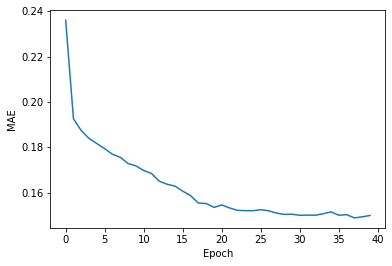

In [52]:
# Plot the mae graph for min temperature model
plt.plot(max_hist.history['mae'])
plt.xlabel('Epoch')
plt.ylabel('MAE')

In [53]:
x_test,y_test=add_time_step(max_test,max_test["Maximum temperature (Degree C)"],210)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [54]:
predicted_temp=max_model.predict(x_test,verbose=1)

543/543 [==============================] - 4s 7ms/sample


In [55]:
predicted_temp=predicted_temp.reshape((predicted_temp.shape[0],1))

In [56]:
# Scale the data back to normal form
predicted_temp=max_scaler.inverse_transform(predicted_temp)
y_test=max_scaler.inverse_transform(y_test)

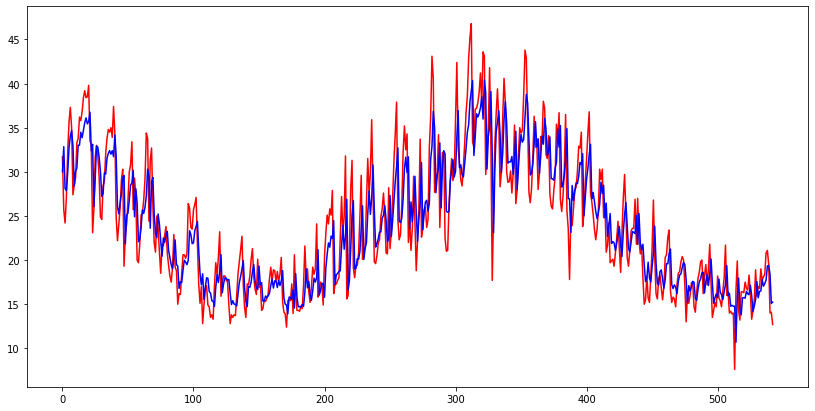

In [57]:
plt.figure(figsize=(14,7))
plt.plot(y_test, color = "red")
plt.plot(predicted_temp,color="blue")

In [58]:
r2_score(y_test,predicted_temp)

0.7871302243865048

## Forecast temperature for next days

In [59]:
def forecast(model,scaler,data,days):
    predicted_data=[]
    historical_data = data
    for i in range(days):
        new_predict = model.predict(historical_data)
        historical_data=np.reshape(historical_data,(historical_data.shape[1]))
        historical_data= np.append(historical_data,new_predict)
        historical_data = historical_data[1::]
        historical_data=np.reshape(historical_data,(1,historical_data.shape[0],1))
        predicted_data.append(scaler.inverse_transform(new_predict))
    return np.array(predicted_data).reshape((days))

In [60]:
forecast_mintemp_data=np.array(min_test[-210:]).reshape((1,210,1))
forecast_maxtemp_data=np.array(max_test[-210:]).reshape((1,210,1))

In [61]:
forecasted_min_data = forecast(min_model,min_scaler,forecast_mintemp_data,200)
forecasted_max_data = forecast(max_model,max_scaler,forecast_maxtemp_data,200)

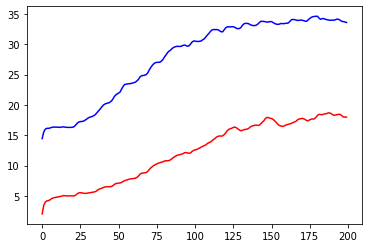

In [64]:
plt.figure()
plt.plot(forecasted_min_data, color = "red")
plt.plot(forecasted_max_data,color="blue")

In [66]:
start_date = min_test[-210:].index[-1] + timedelta(days=1)
end_date = min_test[-210:].index[-1] + timedelta(days=200)

In [67]:
predicted_temp_df = pd.DataFrame()

In [68]:
predicted_temp_df["Date Time"]=pd.date_range(start_date, end_date)
predicted_temp_df['Minimum temperature (Degree C)']= forecasted_min_data
predicted_temp_df['Maximum temperature (Degree C)']= forecasted_max_data
predicted_temp_df["stationname"]= "MILDURA AIRPORT "
predicted_temp_df["localgovernmentarea"] ="Mildura Shire"
predicted_temp_df["latitude"] = -34.2358	
predicted_temp_df["longtitude"] = 142.0867

In [69]:
predicted_temp_df

,Date Time,Minimum temperature (Degree C),Maximum temperature (Degree C),stationname,localgovernmentarea,latitude,longtitude
0,2020-08-07,2.014128,14.445015,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867
1,2020-08-08,3.401633,15.500580,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867
2,2020-08-09,3.954972,15.998637,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867
3,2020-08-10,4.149411,16.132168,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867
4,2020-08-11,4.214590,16.136932,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867
...,...,...,...,...,...,...,...
195,2021-02-18,18.415260,33.944450,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867
196,2021-02-19,18.197697,33.777840,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867
197,2021-02-20,17.998434,33.747883,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867
198,2021-02-21,17.992771,33.684883,MILDURA AIRPORT,Mildura Shire,-34.2358,142.0867


In [71]:
predicted_temp_df.to_csv("sample_forcasted_min_temperature.csv",index=False)